# Vietnam Food Review Sentiment Classifier

## Section 1: EDA

In [1]:
import pandas as pd
from rich import print

positive_file_path = '../data/raw/positive_data.csv'
negative_file_path = '../data/raw/negative_data.csv'
neutral_file_path = '../data/raw/neural_data.csv'

files = [positive_file_path, negative_file_path, neutral_file_path]

# positive_reviews_df = pd.read_csv(positive_file_path)
# negative_reviews_df = pd.read_csv(negative_file_path)
# neutral_reviews_df = pd.read_csv(neutral_file_path)
combined_reviews_df = pd.concat([pd.read_csv(file) for file in files])

First, we check if any rows have `NaN` values.

In [2]:
len(combined_reviews_df)

5914

In [3]:
nan_rows = combined_reviews_df.loc[combined_reviews_df.isna().any(axis=1)]
nan_rows

,Rate,Review,Label
337,4.2,Lúc mình đến bạn phục vụ bàn đang ăn bánh cuố...,NaN
382,4.2,ăn Không gian Nhân viên ngoan bây không cho e...,NaN
813,4.6,Nhìn địa chỉ gì mà Bis tức là Đi từ phố huế r...,NaN
1083,qua mất lại phải đi vòng quay lại vào đây uốn...,0,NaN


As there are only 4 rows with missing labels out of 5914 samples, we remove the rows

In [4]:
combined_reviews_df = combined_reviews_df.dropna()

In [5]:
# Drop rows with NaN
combined_reviews_df = combined_reviews_df.dropna()

# Reset the index column
combined_reviews_df.reset_index(drop=True)
num_rows = combined_reviews_df.shape[0]
combined_reviews_df['Index'] = range(num_rows)
combined_reviews_df.set_index('Index', inplace=True)

In [6]:
# We expect Rate to be float64 while Label to be int32
combined_reviews_df = combined_reviews_df.astype({'Rate': 'float64'})
combined_reviews_df = combined_reviews_df.astype({'Label': 'int32'})

# Let's also count the total number of words in each review
combined_reviews_df['word_count'] = combined_reviews_df['Review'].str.split().apply(len) 

Now let's get 3 separate dataframes based on the sentiment label of `1: positive, 0: neutral, -1: negative`

In [7]:
# Positive overview
positive_df = combined_reviews_df[combined_reviews_df['Label'] == 1]

# Negative overview
negative_df = combined_reviews_df[combined_reviews_df['Label'] == -1]

# Neutral overview
neutral_df = combined_reviews_df[combined_reviews_df['Label'] == 0]

In [8]:
# Positive stats:
print(f"Positive:\n{positive_df.describe()}")

# Negative stats:
print(f"Negative:\n{negative_df.describe()}")

# Neutral stats
print(f"Neutral:\n{neutral_df.describe()}")

Positive:
              Rate   Label   word_count
count  2779.000000  2779.0  2779.000000
mean      9.163512     1.0    71.879813
std       1.039248     0.0    74.308678
min       4.200000     1.0     1.000000
25%       9.000000     1.0    22.000000
50%       9.200000     1.0    50.000000
75%       9.600000     1.0    99.000000
max      10.000000     1.0   972.000000

Negative:
              Rate   Label   word_count
count  2416.000000  2416.0  2416.000000
mean      3.317632    -1.0    91.695364
std       1.218540     0.0    91.331566
min       1.000000    -1.0     1.000000
25%       2.600000    -1.0    32.000000
50%       3.600000    -1.0    66.000000
75%       4.200000    -1.0   116.250000
max       5.000000    -1.0   928.000000

Neutral:
             Rate  Label   word_count
count  715.000000  715.0   715.000000
mean     4.769510    0.0    64.135664
std      0.332075    0.0    76.688115
min      0.000000    0.0     1.000000
25%      4.600000    0.0    20.000000
50%      5.000000    0.0    44.000000
75%      5.000000    0.0    86.000000
max      5.000000    0.0  1046.000000

In [9]:
# From the above, we can see the distribution of labels as follows:
print(f"Positive: {len(positive_df)/len(combined_reviews_df):.2f}, Negative: {len(negative_df)/len(combined_reviews_df):.2f}, Neutral: {len(neutral_df)/len(combined_reviews_df):.2f}")

Positive: 0.47, Negative: 0.41, Neutral: 0.12

### Observations
- The dataset is almost evenly split between `Positive` and `Negative`, with `Neutral` accounting for a small percentage
- The range for `Positive` reviews is broader (4.2 - 10.0) as compared to `Negative` (1.0 - 5.0) and `Neutral` (0.0 - 5.0)
- Some ratings in `Positive` overlaps with `Negative`
- `Neutral` has a lower min rating as compared to `Negative`
- Most reviews have around 60-90 words, with `Negative` reviews having 20 more words than `Positive` reviews on average

### Rating distribution analysis

To properly see the rating distribution across the three labels, let's plot a graph.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions(df, column, num_bins=10, title=10):
    ax = sns.displot(df[column], bins = num_bins, kde=False)
    plt.yscale("log")
    plt.title(title)
    plt.show()

    # Get the count of each bin
    bins = np.histogram_bin_edges(df[column], bins=num_bins)
    values, _= np.histogram(df[column], bins=bins)
    values = [float(value) for value in values]

    # Get the percentage of each bin
    percentages = [value/sum(values) for value in values]
    percentages = [round(percentage,2) for percentage in percentages]

    bin_stats = []
    for i, value in enumerate(values):
        bin_stats.append(
            {
            "bin_lower": round(bins[i], 2),
            "bin_upper": round(bins[i+1], 2),
            "value": round(value, 2),
            "percentage": round(percentages[i], 2),
            }
        )
    print(bin_stats)


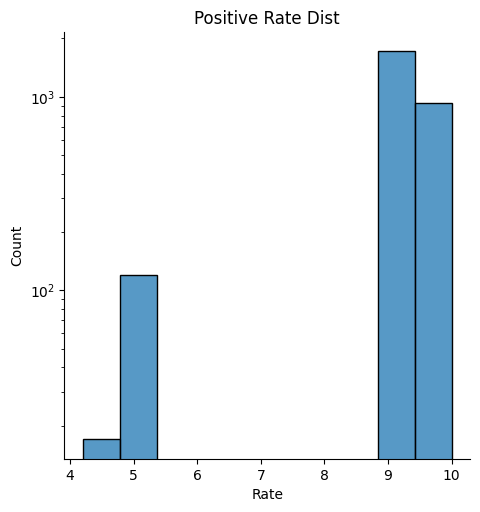

[
    {'bin_lower': 4.2, 'bin_upper': 4.78, 'value': 17.0, 'percentage': 0.01},
    {'bin_lower': 4.78, 'bin_upper': 5.36, 'value': 120.0, 'percentage': 0.04},
    {'bin_lower': 5.36, 'bin_upper': 5.94, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 5.94, 'bin_upper': 6.52, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 6.52, 'bin_upper': 7.1, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 7.1, 'bin_upper': 7.68, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 7.68, 'bin_upper': 8.26, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 8.26, 'bin_upper': 8.84, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 8.84, 'bin_upper': 9.42, 'value': 1715.0, 'percentage': 0.62},
    {'bin_lower': 9.42, 'bin_upper': 10.0, 'value': 927.0, 'percentage': 0.33}
]

In [11]:
plot_distributions(positive_df, "Rate", 10, "Positive Rate Dist")

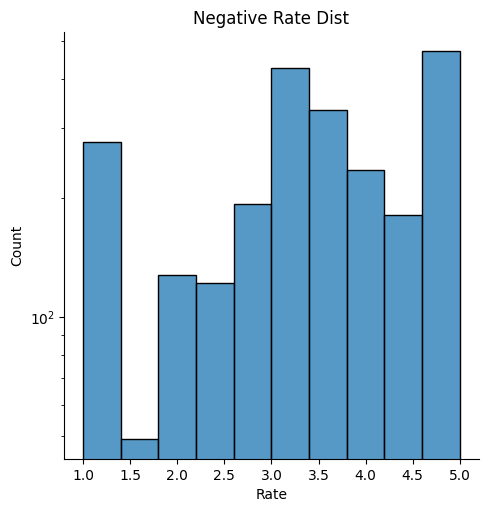

[
    {'bin_lower': 1.0, 'bin_upper': 1.4, 'value': 277.0, 'percentage': 0.11},
    {'bin_lower': 1.4, 'bin_upper': 1.8, 'value': 49.0, 'percentage': 0.02},
    {'bin_lower': 1.8, 'bin_upper': 2.2, 'value': 128.0, 'percentage': 0.05},
    {'bin_lower': 2.2, 'bin_upper': 2.6, 'value': 122.0, 'percentage': 0.05},
    {'bin_lower': 2.6, 'bin_upper': 3.0, 'value': 193.0, 'percentage': 0.08},
    {'bin_lower': 3.0, 'bin_upper': 3.4, 'value': 426.0, 'percentage': 0.18},
    {'bin_lower': 3.4, 'bin_upper': 3.8, 'value': 334.0, 'percentage': 0.14},
    {'bin_lower': 3.8, 'bin_upper': 4.2, 'value': 236.0, 'percentage': 0.1},
    {'bin_lower': 4.2, 'bin_upper': 4.6, 'value': 181.0, 'percentage': 0.07},
    {'bin_lower': 4.6, 'bin_upper': 5.0, 'value': 470.0, 'percentage': 0.19}
]

In [12]:
plot_distributions(negative_df, "Rate", 10, "Negative Rate Dist")

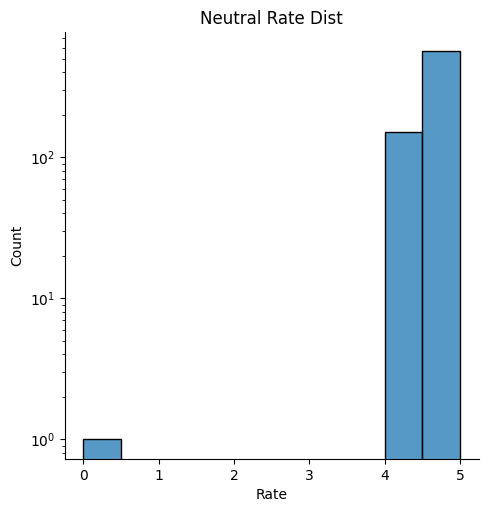

[
    {'bin_lower': 0.0, 'bin_upper': 0.5, 'value': 1.0, 'percentage': 0.0},
    {'bin_lower': 0.5, 'bin_upper': 1.0, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 1.0, 'bin_upper': 1.5, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 1.5, 'bin_upper': 2.0, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 2.0, 'bin_upper': 2.5, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 2.5, 'bin_upper': 3.0, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 3.0, 'bin_upper': 3.5, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 3.5, 'bin_upper': 4.0, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 4.0, 'bin_upper': 4.5, 'value': 150.0, 'percentage': 0.21},
    {'bin_lower': 4.5, 'bin_upper': 5.0, 'value': 564.0, 'percentage': 0.79}
]

In [13]:
plot_distributions(neutral_df, "Rate", 10, "Neutral Rate Dist")

From the above, we see that positive and neutral (to a lesser extent) has 2 distinct distributions
- `Positive`: There are 137/2779 ratings (5%) congregating around 4 to 5, while the rest of the ratings congregate at high 8's to 10s
- `Neutral`: There is 1 rating with a score of 0, while the rest are between 4 to 5.

This observation does not happen in `Negative` as it is rather spread out from 1 to 5.
Hence, we may wish to remove the lower distributions from `Positive` and `Neutral` later on.

### Distribution of words
Let's check out the review lengths for each dataset

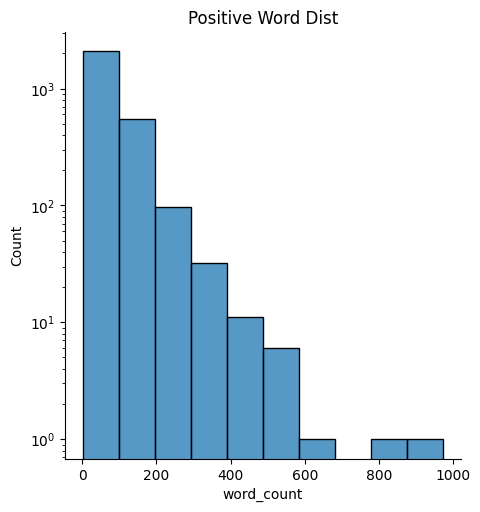

[
    {'bin_lower': 1.0, 'bin_upper': 98.1, 'value': 2078.0, 'percentage': 0.75},
    {'bin_lower': 98.1, 'bin_upper': 195.2, 'value': 553.0, 'percentage': 0.2},
    {'bin_lower': 195.2, 'bin_upper': 292.3, 'value': 96.0, 'percentage': 0.03},
    {'bin_lower': 292.3, 'bin_upper': 389.4, 'value': 32.0, 'percentage': 0.01},
    {'bin_lower': 389.4, 'bin_upper': 486.5, 'value': 11.0, 'percentage': 0.0},
    {'bin_lower': 486.5, 'bin_upper': 583.6, 'value': 6.0, 'percentage': 0.0},
    {'bin_lower': 583.6, 'bin_upper': 680.7, 'value': 1.0, 'percentage': 0.0},
    {'bin_lower': 680.7, 'bin_upper': 777.8, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 777.8, 'bin_upper': 874.9, 'value': 1.0, 'percentage': 0.0},
    {'bin_lower': 874.9, 'bin_upper': 972.0, 'value': 1.0, 'percentage': 0.0}
]

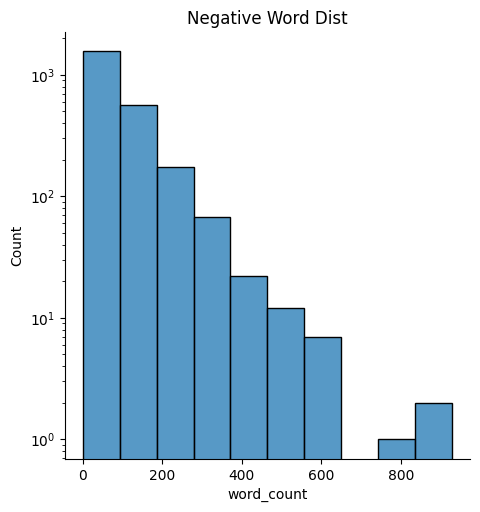

[
    {'bin_lower': 1.0, 'bin_upper': 93.7, 'value': 1562.0, 'percentage': 0.65},
    {'bin_lower': 93.7, 'bin_upper': 186.4, 'value': 568.0, 'percentage': 0.24},
    {'bin_lower': 186.4, 'bin_upper': 279.1, 'value': 175.0, 'percentage': 0.07},
    {'bin_lower': 279.1, 'bin_upper': 371.8, 'value': 67.0, 'percentage': 0.03},
    {'bin_lower': 371.8, 'bin_upper': 464.5, 'value': 22.0, 'percentage': 0.01},
    {'bin_lower': 464.5, 'bin_upper': 557.2, 'value': 12.0, 'percentage': 0.0},
    {'bin_lower': 557.2, 'bin_upper': 649.9, 'value': 7.0, 'percentage': 0.0},
    {'bin_lower': 649.9, 'bin_upper': 742.6, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 742.6, 'bin_upper': 835.3, 'value': 1.0, 'percentage': 0.0},
    {'bin_lower': 835.3, 'bin_upper': 928.0, 'value': 2.0, 'percentage': 0.0}
]

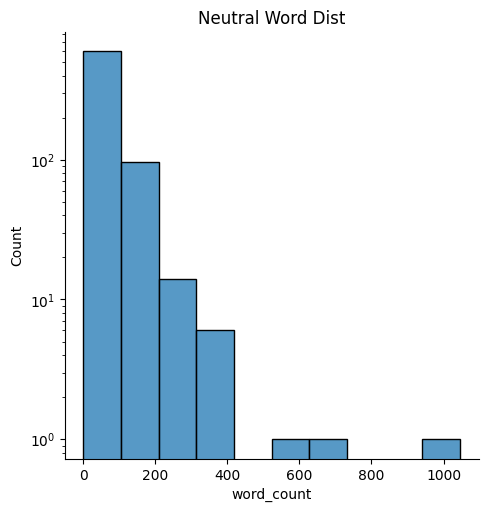

[
    {'bin_lower': 1.0, 'bin_upper': 105.5, 'value': 596.0, 'percentage': 0.83},
    {'bin_lower': 105.5, 'bin_upper': 210.0, 'value': 96.0, 'percentage': 0.13},
    {'bin_lower': 210.0, 'bin_upper': 314.5, 'value': 14.0, 'percentage': 0.02},
    {'bin_lower': 314.5, 'bin_upper': 419.0, 'value': 6.0, 'percentage': 0.01},
    {'bin_lower': 419.0, 'bin_upper': 523.5, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 523.5, 'bin_upper': 628.0, 'value': 1.0, 'percentage': 0.0},
    {'bin_lower': 628.0, 'bin_upper': 732.5, 'value': 1.0, 'percentage': 0.0},
    {'bin_lower': 732.5, 'bin_upper': 837.0, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 837.0, 'bin_upper': 941.5, 'value': 0.0, 'percentage': 0.0},
    {'bin_lower': 941.5, 'bin_upper': 1046.0, 'value': 1.0, 'percentage': 0.0}
]

In [14]:
plot_distributions(positive_df, "word_count", 10, "Positive Word Dist")
plot_distributions(negative_df, "word_count", 10, "Negative Word Dist")
plot_distributions(neutral_df, "word_count", 10, "Neutral Word Dist")

From the above distributions, we see most reviews having less than 100 words. Hence, we may want to ignore reviews that are too long or too short (outliers) as it may introduce noise into the model.

### Looking at the texts
While looking through the dataset, some examples had a mix of English and Vietnamese, and a very few minority of reviews were in English. Some examples are shown below

In [15]:
negative_df.iloc[20:30]

,Rate,Review,Label,word_count
Index,,,,
2662,3.2,Mình ăn caramen ở đây vị cũng ko có gì đặc sắ...,-1,34
2663,1.0,Food is But boss is a we asked for the price ...,-1,72
2664,2.8,Shipper đến muộn Sữa chua chưa lên men,-1,8
2665,2.2,Lúc đầu mình mới bước vào quán thấy hơi ngộp ...,-1,117
2666,3.2,Mấy bạn trông xe của quán ở phía Lotteria quá...,-1,48
2667,3.2,Mình ăn ở đây do thấy các bạn khen rất ăn xon...,-1,66
2668,4.0,Đi ăn kem dừa ở đây thực sự là thấy quá thì q...,-1,98
2669,3.0,Mới ăn kem và bánh Giá hạt ze nhưng chẳng ngo...,-1,47
2670,2.8,Nhà hàng này sẽ làm hỏng hình ảnh của hệ thốn...,-1,40


We see in Index 2663 (from `negative_df`), the review is entirely in English, while in 2665 and 2666, there are some nouns in English. Hence we may need to use a multi-lingual tokenizer to address this, or remove all non-Vietnamese reviews

## Section 2: Data Processing
Let's do some of these preliminary steps to process the data:
- Lowercase `Review` column
- Remove Vietnamese stopwords
- Perform lemmatization if needed
- Use a multi-lingual tokenizer

### Apply lowercasing

In [16]:
# Lowercase Review column
combined_reviews_df["Review"] = combined_reviews_df["Review"].str.lower()

In [17]:
combined_reviews_df.head(5)

,Rate,Review,Label,word_count
Index,,,,
0,9.0,khu ẩm thực với đa dạng đồ lại còn bày trí đẹ...,1,111
1,9.0,lúc nào đến aeon là lúc đấy phải tống một đốn...,1,89
2,10.0,bánh ngon lại rẻ chê đâu được gần hết các loạ...,1,18
3,9.0,ngon rẻ,1,2
4,9.6,tôi sắp chết vì ngập trong sushi mấttttt lên ...,1,42


### Removing stopwords

In [18]:
import nltk
from typing import List

def remove_vn_stopwords(text: str):
    vn_stopwords_file = open("../data/vietnamese-stopwords.txt", encoding="utf8")
    vn_stopwords = vn_stopwords_file.read()
    vn_stopwords = vn_stopwords.split("\n")

    for stopword in vn_stopwords:
        text = text.replace(stopword, "")
    return text

In [ ]:
combined_reviews_df["Review"] = combined_reviews_df["Review"].apply(remove_vn_stopwords)

# Let's also update the word_count
combined_reviews_df['word_count'] = combined_reviews_df['Review'].str.split().apply(len) 

In [ ]:
combined_reviews_df.head(5)

Let's check out the word count distribution for each label dataset again

In [ ]:
# Positive overview
positive_df = combined_reviews_df[combined_reviews_df['Label'] == 1]

# Negative overview
negative_df = combined_reviews_df[combined_reviews_df['Label'] == -1]

# Neutral overview
neutral_df = combined_reviews_df[combined_reviews_df['Label'] == 0]

In [ ]:
plot_distributions(positive_df, "word_count", 10, "Positive Word Dist")
plot_distributions(negative_df, "word_count", 10, "Negative Word Dist")
plot_distributions(neutral_df, "word_count", 10, "Neutral Word Dist")

Hence, through the removal of stopwords, we see that on average, half of the contents were removed. This may help us with reducing the amount of noise introduced into the model.

### Tokenization

Tokenization will be handled with HuggingFace's AutoTokenizer. However, a preview of how the tokenization will look like will be shown below

In [ ]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

checkpoint = "trituenhantaoio/bert-base-vietnamese-uncased"
model = BertForSequenceClassification.from_pretrained(checkpoint)
tokenizer = BertTokenizer.from_pretrained(checkpoint)

mini_df = combined_reviews_df.head(5)
mini_df["Review"] = mini_df["Review"].apply(tokenizer.tokenize)

In [ ]:
mini_df.head(5)

# Preparing new data
- We load the above pandas dataframe in Arrow format
- Following that, we split the dataset into train, val and tes

In [ ]:
from datasets import Dataset

# Shuffle the dataset
combined_reviews_df = combined_reviews_df.sample(frac=1)

# Remap the labels to 0, 1, 2 instead of -1, 0, 1
combined_reviews_df["Label"] = combined_reviews_df["Label"].map({-1: 0, 0: 1, 1: 2})
combined_reviews_df["Label"] = combined_reviews_df["Label"].astype(int)

# Convert to Arrow format
reviews_dataset = Dataset.from_pandas(combined_reviews_df)
reviews_dataset

In [ ]:
# Split into train and test
reviews_dataset = reviews_dataset.train_test_split(train_size=0.8, seed=42)

# Split train into train and val
cleaned_reviews_dataset = reviews_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename "test" to "validation"
cleaned_reviews_dataset["validation"] = cleaned_reviews_dataset.pop("test")
# Add back original "test" data
cleaned_reviews_dataset["test"] = reviews_dataset["test"]

cleaned_reviews_dataset


# Modelling

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "trituenhantaoio/bert-base-vietnamese-uncased"
# checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["Review"], truncation=True, max_length=512)

tokenized_datasets = cleaned_reviews_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Process the dataset
# Drop unused columns
tokenized_datasets = tokenized_datasets.remove_columns(['Rate', 'Review', 'word_count', 'Index'])
# Rename label column
tokenized_datasets = tokenized_datasets.rename_column('Label', 'label')
# Set to PyTorch tensors
# tokenized_datasets.set_format("torch")

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline

import evaluate
import os

os.environ["CURL_CA_BUNDLE"]=""

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = -1)
    print(predictions)
    print("****")
    print(labels)
    matches = sum(1 for pred, label in zip(predictions, labels) if pred == label)
    accuracy = matches / len(predictions) * 100
    print(accuracy)
    return {"accuracy": accuracy}

sst_training_args = TrainingArguments("sst-trainer", per_device_train_batch_size=8, evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


sst_trainer = Trainer(
    model,
    args=sst_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

sst_trainer.train()

metrics = sst_trainer.evaluate()

print(metrics)